In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier

Data exploration and preparation

In [2]:
df= pd.read_csv(r"C:\Users\Essam\Desktop\ML Project\Arabic-Characters-Recognition\csvTrainImages 13440x1024.csv",header=None)
df_labels=pd.read_csv(r"C:\Users\Essam\Desktop\ML Project\Arabic-Characters-Recognition\csvTrainLabel 13440x1.csv",header=None )
images = df.to_numpy()
normalized_images=images/255.

df_test = pd.read_csv(r"C:\Users\Essam\Desktop\ML Project\Arabic-Characters-Recognition\csvTestImages 3360x1024.csv",header=None)
df_labels_test = pd.read_csv(r"C:\Users\Essam\Desktop\ML Project\Arabic-Characters-Recognition\csvTestLabel 3360x1.csv",header=None)
df_labels_test.to_numpy
images_t = df_test.to_numpy()
images_test=images_t/255.

In [3]:
unique_classes = df_labels[0].unique()
print("Unique Classes:", unique_classes)

Unique Classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]


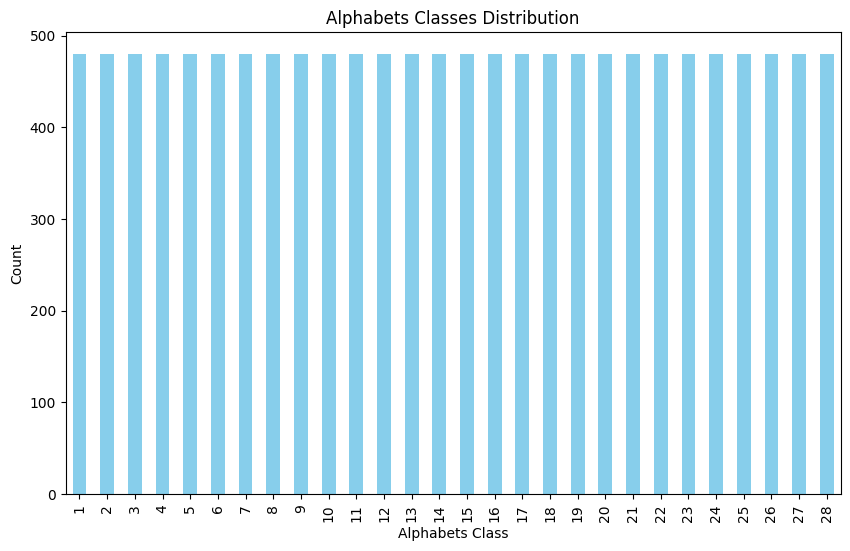

In [4]:
class_distribution = df_labels[0].value_counts()
plt.figure(figsize=(10, 6))
class_distribution = class_distribution.sort_index()
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Alphabets Classes Distribution')
plt.xlabel('Alphabets Class')
plt.ylabel('Count')
plt.show()

In [5]:
def display_image(image):
    image_size = 32
    images = image.reshape((image_size, image_size))
    plt.imshow(images, cmap='gray')
    plt.axis('off')
    plt.show()

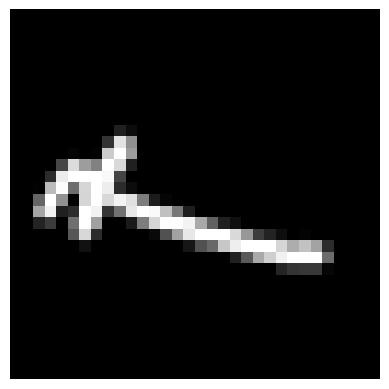

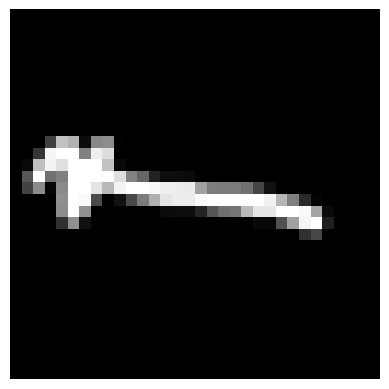

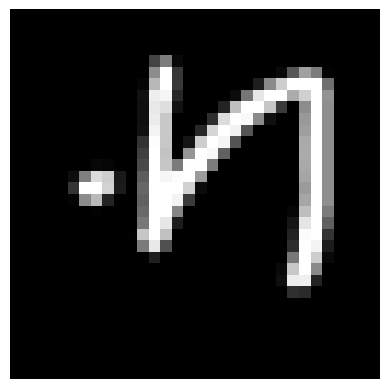

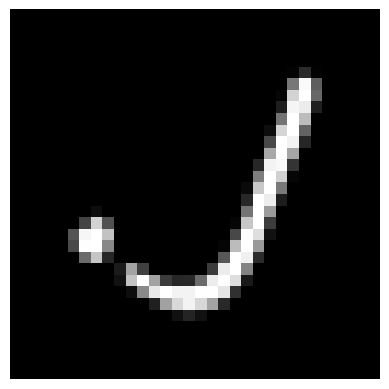

In [6]:
display_image(images[0])
display_image(images[3])
display_image(images[54])
display_image(images[80])

In [7]:
df_labels = df_labels.to_numpy()
df_labels_test = df_labels_test.to_numpy()
print(df_labels.dtype)
print(df_labels_test.dtype)

int64
int64


First Experiment Support Vector Machine (SVM)

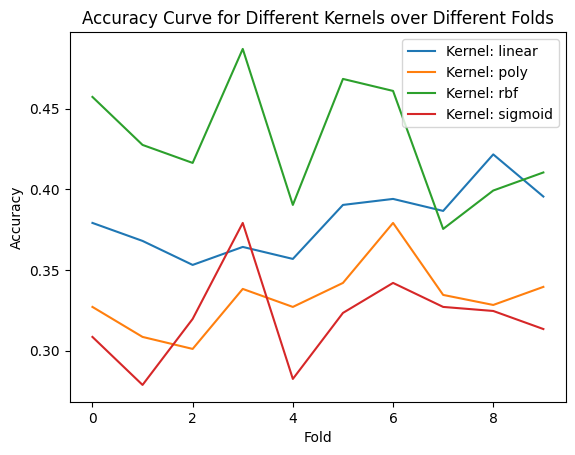

In [8]:
X_train, X_test, y_train, y_test = train_test_split(normalized_images, df_labels, test_size=0.2, random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_accuracies = {kernel: [] for kernel in kernels}
for train_index, val_index in kf.split(X_test, y_test):
    X_val_train, X_val_test = X_test[train_index], X_test[val_index]
    y_val_train, y_val_test = y_test[train_index], y_test[val_index]
    for kernel in kernels:
        svm_model = SVC(kernel=kernel)
        svm_model.fit(X_val_train, y_val_train.ravel())
        y_val_pred = svm_model.predict(X_val_test)
        accuracy = accuracy_score(y_val_test.ravel(), y_val_pred)
        kernel_accuracies[kernel].append(accuracy)
for kernel, accuracies in kernel_accuracies.items():
    plt.plot(accuracies, label=f'Kernel: {kernel}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Different Kernels over Different Folds')
plt.legend()
plt.show()

After splitting test data into 10 K-folds and test each kernel in each fold , we found that when kernel = 'rbf' ,The model performace is the highest

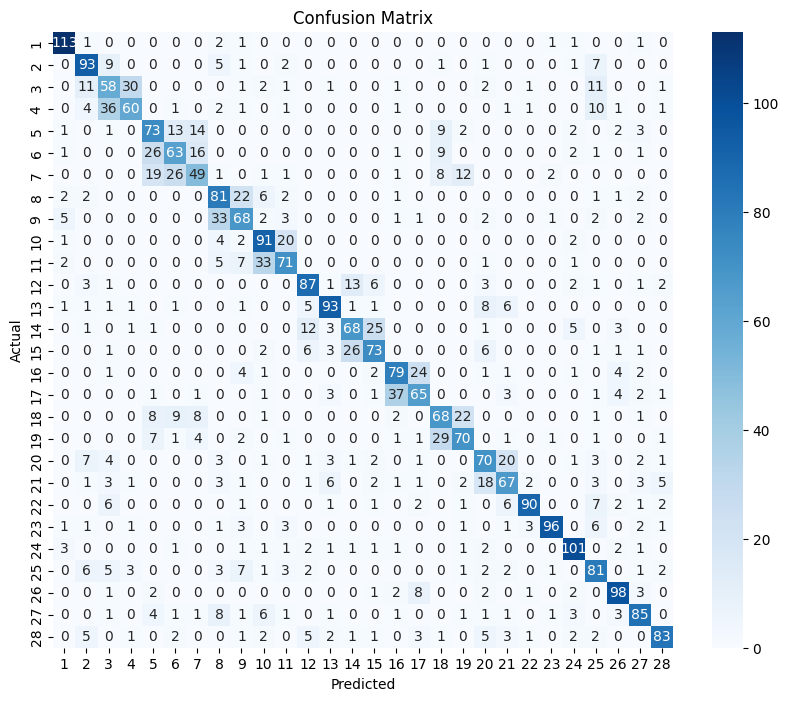

Average F1 Score: 0.6529761904761905


In [9]:
# Train an SVM model on training data
SVM_model = SVC(kernel='rbf', C=1.0, random_state=42)
SVM_model.fit(normalized_images, df_labels.ravel())

# Test the model on the test data
predictions_svm = SVM_model.predict(images_test)

# confusion matrix
conf_matrix = confusion_matrix(df_labels_test.ravel(), predictions_svm)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# average f1-score
average_f1_score_svm = f1_score(df_labels_test.ravel(), predictions_svm, average='micro')
print("Average F1 Score:", average_f1_score_svm)

Second Experiment KNN

In [10]:
X_train, X_val, y_train, y_val = train_test_split(normalized_images, df_labels, test_size=0.1, random_state=42,shuffle=True)

In [11]:
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train)
y_val_onehot = encoder.transform(y_val)

c:\Users\Essam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
def train_and_evaluate_knn(X_train, y_train, X_val, y_val, k_values):
    f1_scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_val_pred = knn.predict(X_val)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        f1_scores.append(f1)
        print(f"K={k}, F1 Score (weighted): {f1}")

    return f1_scores

In [13]:
k_values = [1, 3, 5, 7, 9]
average_f1_scores = train_and_evaluate_knn(X_train, y_train_onehot, X_val, y_val_onehot, k_values)

K=1, F1 Score (weighted): 0.524647332275423
K=3, F1 Score (weighted): 0.4583997805530425
K=5, F1 Score (weighted): 0.422321550594203
K=7, F1 Score (weighted): 0.3805427289780064
K=9, F1 Score (weighted): 0.3381732377759577


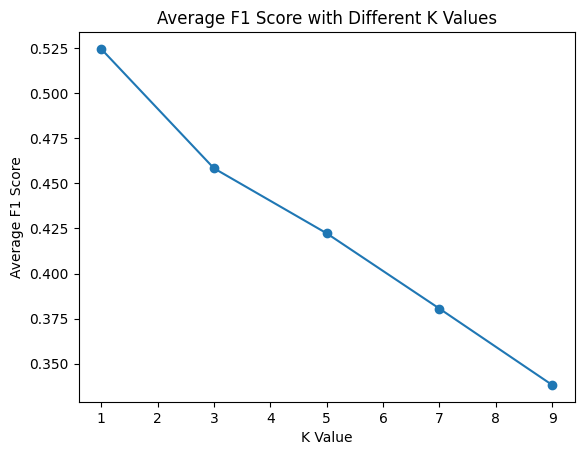

In [14]:
plt.plot(k_values, average_f1_scores, marker='o')
plt.title('Average F1 Score with Different K Values')
plt.xlabel('K Value')
plt.ylabel('Average F1 Score')
plt.show()

In [15]:
best_k = k_values[np.argmax(average_f1_scores)]
print(f"The best K value is: {best_k}")

final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(X_train, y_train_onehot)

The best K value is: 1


KNeighborsClassifier(n_neighbors=1)

In [16]:
y_test_onehot = encoder.transform(df_labels_test)
y_test_pred = final_knn_model.predict(images_test)
f1_test = f1_score(y_test_onehot, y_test_pred, average='weighted')

In [17]:
print(f"\nTest F1 Score (weighted): {f1_test}")


Test F1 Score (weighted): 0.5508777566941211


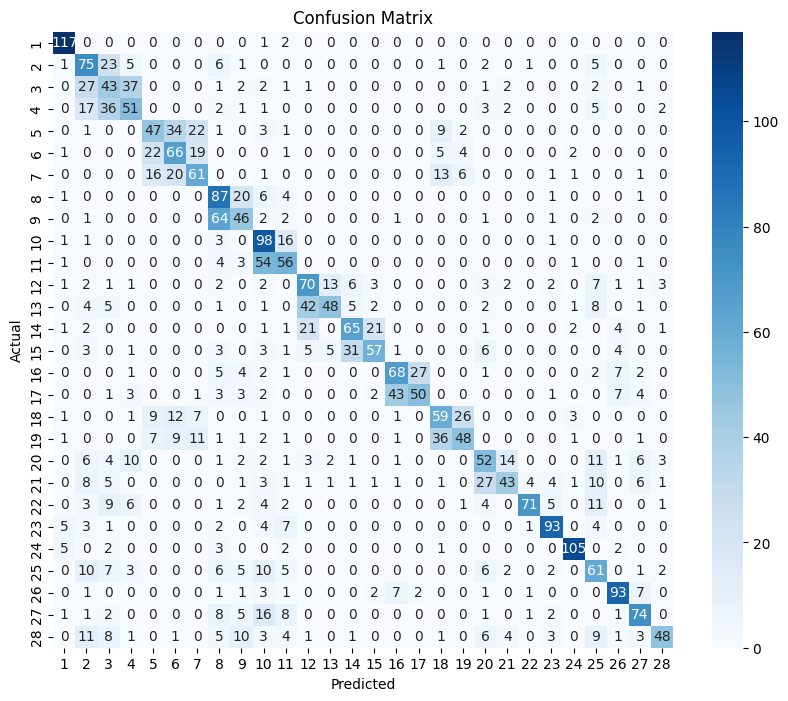

In [18]:
y_test_true_onehot = encoder.transform(df_labels_test)
conf_matrix = confusion_matrix(y_test_true_onehot.argmax(axis=1), y_test_pred.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Third Experiment Neural Network (NN)

In [19]:
def build_model_1(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.Dense(32, input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(28, activation='softmax'))
    return model

def build_model_2(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.Dense(128, input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(420, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(612, activation='relu'))
    model.add(tf.keras.layers.Dense(612, activation='relu'))
    model.add(tf.keras.layers.Dense(28, activation='softmax'))
    return model

In [20]:
X_train, X_val, y_train, y_val = train_test_split(normalized_images, df_labels, test_size=0.05, random_state=42,shuffle=True)

In [21]:
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train)
y_val_onehot = encoder.transform(y_val)

c:\Users\Essam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
399/399 [==============================] - 2s 3ms/step - loss: 2.2782 - accuracy: 0.2785 - val_loss: 1.6989 - val_accuracy: 0.4524
Epoch 2/30
 67/399 [====>.........................] - ETA: 0s - loss: 1.5817 - accuracy: 0.4641

c:\Users\Essam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


399/399 [==============================] - 1s 3ms/step - loss: 1.4621 - accuracy: 0.4926 - val_loss: 1.3324 - val_accuracy: 0.5461
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 1.1792 - accuracy: 0.5793 - val_loss: 1.2437 - val_accuracy: 0.5699
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 1.0096 - accuracy: 0.6349 - val_loss: 1.1077 - val_accuracy: 0.6027
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.8999 - accuracy: 0.6687 - val_loss: 1.1069 - val_accuracy: 0.6042
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.8118 - accuracy: 0.7045 - val_loss: 1.1363 - val_accuracy: 0.6190
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - loss: 0.7457 - accuracy: 0.7234 - val_loss: 1.0712 - val_accuracy: 0.6190
Epoch 8/30
399/399 [==============================] - 1s 2ms/step - loss: 0.6829 - accuracy: 0.7494 - val_loss: 1.0254 - val_accuracy: 0.6473
Epoch 9/30
399/39

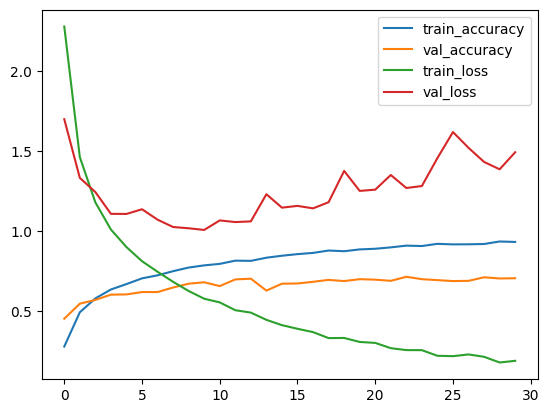

Epoch 1/30
399/399 [==============================] - 5s 11ms/step - loss: 2.3379 - accuracy: 0.2238 - val_loss: 1.7902 - val_accuracy: 0.3482
Epoch 2/30
399/399 [==============================] - 4s 11ms/step - loss: 1.4624 - accuracy: 0.4519 - val_loss: 1.3921 - val_accuracy: 0.4866
Epoch 3/30
399/399 [==============================] - 4s 11ms/step - loss: 1.1451 - accuracy: 0.5665 - val_loss: 1.2070 - val_accuracy: 0.5744
Epoch 4/30
399/399 [==============================] - 4s 11ms/step - loss: 0.9390 - accuracy: 0.6418 - val_loss: 1.1311 - val_accuracy: 0.5804
Epoch 5/30
399/399 [==============================] - 4s 11ms/step - loss: 0.7844 - accuracy: 0.6985 - val_loss: 1.1403 - val_accuracy: 0.6042
Epoch 6/30
399/399 [==============================] - 4s 11ms/step - loss: 0.7066 - accuracy: 0.7329 - val_loss: 1.0028 - val_accuracy: 0.6235
Epoch 7/30
399/399 [==============================] - 4s 11ms/step - loss: 0.5986 - accuracy: 0.7734 - val_loss: 1.0013 - val_accuracy: 0.6771

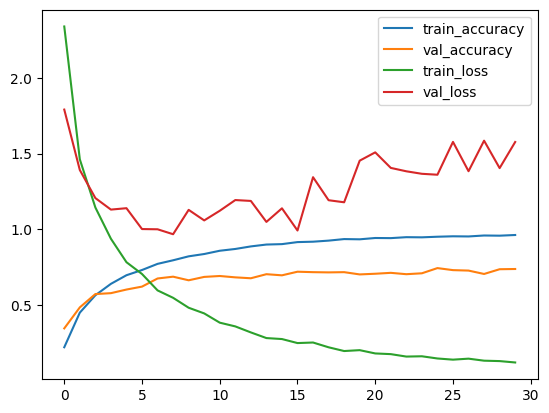

In [22]:
def train_and_plot(model, X_train, y_train, X_val, y_val, model_name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Add a ModelCheckpoint callback to save the best model
    checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])
    
    # Plot training and validation curves
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

# Reshape input data if needed
input_shape = X_train.shape[1:]

# Example usage
model_1 = build_model_1(input_shape)
train_and_plot(model_1, X_train, y_train_onehot, X_val, y_val_onehot, 'model_1.h5')

model_2 = build_model_2(input_shape)
train_and_plot(model_2, X_train, y_train_onehot, X_val, y_val_onehot, 'model_2.h5')

In [23]:
best_model = load_model('model_2.h5')
y_pred_probabilities = best_model.predict(images_test)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_pred_classes+=1

105/105 [==============================] - 1s 6ms/step


In [24]:
accuracy = accuracy_score(df_labels_test, y_pred_classes)
f1 = f1_score(df_labels_test, y_pred_classes, average='weighted') 

print("Accuracy:", accuracy)
print("\nF1 Score (weighted):", f1)

Accuracy: 0.7264880952380952

F1 Score (weighted): 0.7250434019718293


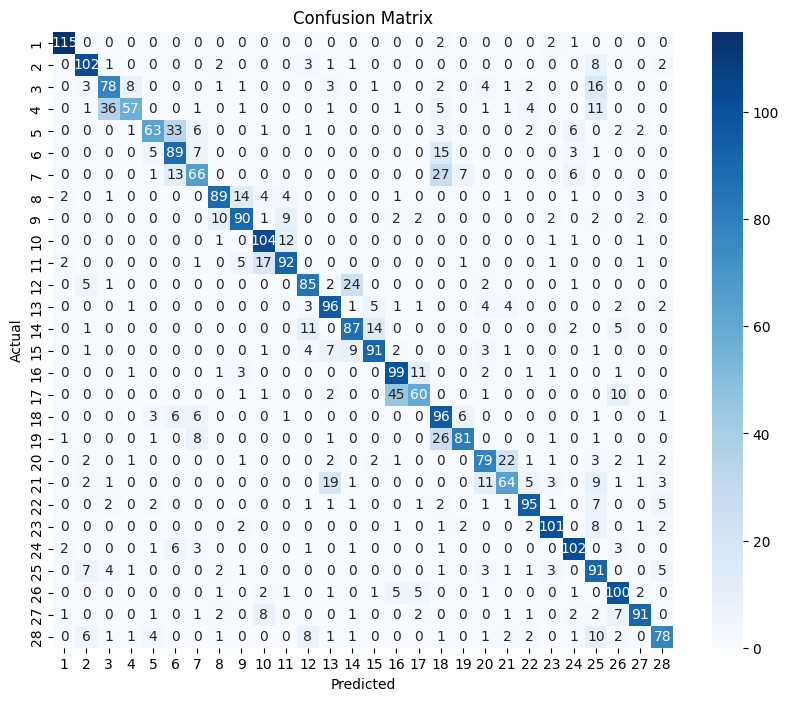

In [25]:
conf_matrix = confusion_matrix(df_labels_test, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.show()
plt.show()